In [39]:
# Document Collection, Tokenizer, Normalization Pipeline on IMDB dataset
import os
import tarfile
import random
import pandas as pd
import numpy as np
import nltk
import logging
import time
import tensorflow as tf
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
nltk.download('punkt')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')


import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mamta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mamta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mamta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [40]:
# --- Use TensorFlow Datasets to load IMDB ---
import tensorflow as tf
import tensorflow_datasets as tfds

# Load IMDB reviews dataset from TensorFlow Datasets
# as_supervised=True gives (text, label) pairs
(ds_train, ds_test), ds_info = tfds.load(
    "imdb_reviews",
    split=["train", "test"],
    as_supervised=True,
    with_info=True
)

# --- Step 2: Collect 1000 positive + 1000 negative from the training split ---

documents = []
pos_count = 0
neg_count = 0
TARGET_PER_CLASS = 1000

# Convert TFDS dataset to NumPy for easy iteration
for text, label in tfds.as_numpy(ds_train.shuffle(25000, seed=42)):
    text_str = text.decode("utf-8")
    label_int = int(label)

    if label_int == 1 and pos_count < TARGET_PER_CLASS:
        documents.append((text_str, "positive"))
        pos_count += 1
    elif label_int == 0 and neg_count < TARGET_PER_CLASS:
        documents.append((text_str, "negative"))
        neg_count += 1

    if pos_count >= TARGET_PER_CLASS and neg_count >= TARGET_PER_CLASS:
        break

print(f"Collected {pos_count} positive and {neg_count} negative reviews.")

# Shuffle the dataset
random.shuffle(documents)

# Convert to pandas DataFrame
df = pd.DataFrame(documents, columns=["text", "label"])
df.head()

2025-12-07 17:13:08,118 : INFO : No config specified, defaulting to config: imdb_reviews/plain_text
2025-12-07 17:13:08,122 : INFO : Load dataset info from C:\Users\mamta\tensorflow_datasets\imdb_reviews\plain_text\1.0.0
2025-12-07 17:13:08,131 : INFO : Creating a tf.data.Dataset reading 1 files located in folders: C:\Users\mamta\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.
2025-12-07 17:13:08,206 : INFO : Creating a tf.data.Dataset reading 1 files located in folders: C:\Users\mamta\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.
2025-12-07 17:13:08,300 : INFO : Constructing tf.data.Dataset imdb_reviews for split ['train', 'test'], from C:\Users\mamta\tensorflow_datasets\imdb_reviews\plain_text\1.0.0


Collected 1000 positive and 1000 negative reviews.


,text,label
0,"Sadly not available on DVD as yet, but worth p...",positive
1,Seriously. This is one of the most stupid fami...,negative
2,Demi Moore's character in the movie was select...,negative
3,"Geez, another Lifetime movie, but once again i...",negative
4,The short that starts this film is the true fo...,positive


In [41]:
print("Dataset shape:", df.shape)
print("\nLabel distribution:")
print(df['label'].value_counts())

df[['text', 'label']].head()


Dataset shape: (2000, 2)

Label distribution:
label
positive    1000
negative    1000
Name: count, dtype: int64


,text,label
0,"Sadly not available on DVD as yet, but worth p...",positive
1,Seriously. This is one of the most stupid fami...,negative
2,Demi Moore's character in the movie was select...,negative
3,"Geez, another Lifetime movie, but once again i...",negative
4,The short that starts this film is the true fo...,positive


In [42]:
first_review = df.loc[0, "text"]
first_review_tokens = word_tokenize(first_review)

print("=== FIRST REVIEW (text sample) ===")
print(first_review[:300], "...")

print("\n=== TOKENIZED OUTPUT ===")
print(first_review_tokens[:30])


=== FIRST REVIEW (text sample) ===
Sadly not available on DVD as yet, but worth pursuing on TCM or VHS. A secretary believes her boss is wrongly accused of murder, and courageously takes on many dangerous characters in an effort to establish the truth. A movie with many twists and dark alleyways, none of which I will mention! The jaz ...

=== TOKENIZED OUTPUT ===
['Sadly', 'not', 'available', 'on', 'DVD', 'as', 'yet', ',', 'but', 'worth', 'pursuing', 'on', 'TCM', 'or', 'VHS', '.', 'A', 'secretary', 'believes', 'her', 'boss', 'is', 'wrongly', 'accused', 'of', 'murder', ',', 'and', 'courageously', 'takes']


In [43]:
def normalize_and_remove_stops(tokens):
    """
    1. Converts all tokens to lowercase (Normalization).
    2. Removes common English stop words.
    """
    # 1. Normalization: Convert to lowercase
    normalized_tokens = [token.lower() for token in tokens]

    # 2. Stop Words Removal
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [token for token in normalized_tokens if token not in stop_words]
    
    return filtered_tokens

# Process our IMDB review tokens
cleaned_tokens = normalize_and_remove_stops(first_review_tokens)

print("--- NORMALIZATION & STOP WORDS REMOVAL ---")
print(cleaned_tokens[:30])


--- NORMALIZATION & STOP WORDS REMOVAL ---
['sadly', 'available', 'dvd', 'yet', ',', 'worth', 'pursuing', 'tcm', 'vhs', '.', 'secretary', 'believes', 'boss', 'wrongly', 'accused', 'murder', ',', 'courageously', 'takes', 'many', 'dangerous', 'characters', 'effort', 'establish', 'truth', '.', 'movie', 'many', 'twists', 'dark']


In [44]:
X = df["text"].values          # raw review text
y = df["label"].values         # "positive" / "negative"

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))

Train size: 1500
Test size : 500


In [45]:
vectorizer = TfidfVectorizer(
    max_features=5000,      # limit vocabulary size for practicality
    ngram_range=(1, 1),     # unigrams only for now
    lowercase=True,         # convert to lowercase
    stop_words='english'    # remove English stopwords
)

# Fit on training data only (to avoid data leakage)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print("\n=== TF-IDF MATRIX INFO ===")
print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape :", X_test_tfidf.shape)


=== TF-IDF MATRIX INFO ===
Train TF-IDF shape: (1500, 5000)
Test TF-IDF shape : (500, 5000)


In [46]:
vocab = vectorizer.get_feature_names_out()
print("\nVocabulary size:", len(vocab))

print("\nSample of first 100 features:")
print(vocab[:100])


Vocabulary size: 5000

Sample of first 100 features:
['00' '000' '10' '100' '11' '12' '13' '14' '15' '16' '17' '18' '19' '1922'
 '1930' '1930s' '1933' '1935' '1936' '1939' '1940' '1943' '1950' '1950s'
 '1960' '1968' '1970' '1970s' '1973' '1978' '1979' '1980' '1980s' '1983'
 '1985' '1990' '1990s' '1996' '1997' '19th' '1st' '20' '2000' '2001'
 '2002' '2003' '2005' '2006' '2007' '2008' '20th' '24' '25' '27' '30'
 '30s' '35' '3rd' '40' '400' '50' '50s' '60' '60s' '70' '70s' '73' '80'
 '80s' '90' '90s' '99' 'abandoned' 'abilities' 'ability' 'able' 'abruptly'
 'absence' 'absolute' 'absolutely' 'absurd' 'abuse' 'abused' 'academic'
 'academy' 'accent' 'accents' 'accept' 'acceptable' 'access' 'accident'
 'accidentally' 'accompanied' 'accomplished' 'according' 'account'
 'accuracy' 'accurate' 'achieve' 'achieved']


In [47]:
doc_index = 0  # first training document
doc_vector = X_train_tfidf[doc_index].toarray().ravel()

# Indices of top 10 highest-weighted terms in this document
top_indices = doc_vector.argsort()[::-1][:10]

print("\n=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===")
print("Original review snippet:")
print(X_train[doc_index][:300], "...")

print("\nTop 10 weighted terms:")
for idx in top_indices:
    term = vocab[idx]
    weight = doc_vector[idx]
    print(f"{term:<20} -> {weight:.4f}")


=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===
Original review snippet:
Like most comments I saw this film under the name of The Witching which is the reissue title. Apparently Necromancy which is the original is better but I doubt it.<br /><br />Most scenes of the witching still include most necromancy scenes and these are still bad. In many ways I think the added nudi ...

Top 10 weighted terms:
br                   -> 0.2712
pamela               -> 0.2434
troma                -> 0.2355
scenes               -> 0.1982
added                -> 0.1763
nudity               -> 0.1738
straight             -> 0.1608
difficult            -> 0.1561
awful                -> 0.1395
bad                  -> 0.1259


In [48]:
total_elements = X_train_tfidf.shape[0] * X_train_tfidf.shape[1]
non_zero = X_train_tfidf.nnz
sparsity = 100.0 * non_zero / total_elements

print("\n=== SPARSITY INFORMATION (TRAIN MATRIX) ===")
print(f"Non-zero entries: {non_zero}")
print(f"Total elements  : {total_elements}")
print(f"Sparsity        : {sparsity:.4f}%")

# Show a tiny dense sample of the TF-IDF matrix (first 5 docs, first 10 features)
sample_dense = X_train_tfidf[:5, :10].toarray()
sample_features = vocab[:10]

print("\n=== SMALL DENSE VIEW (5 docs x 10 features) ===")
sample_df = pd.DataFrame(sample_dense, columns=sample_features)
print(sample_df.round(4))


=== SPARSITY INFORMATION (TRAIN MATRIX) ===
Non-zero entries: 104566
Total elements  : 7500000
Sparsity        : 1.3942%

=== SMALL DENSE VIEW (5 docs x 10 features) ===
    00  000      10  100   11   12   13   14   15   16
0  0.0  0.0  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0475  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0000  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [49]:
# Step 2: TF-IDF Feature Extraction on IMDB Reviews
nltk.download('punkt')
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# We assume df from Step 1 exists with columns: ["text", "label"]

# -----------------------------
# 1. Train-Test Split
# -----------------------------
X = df["text"].values          # raw review text
y = df["label"].values         # "positive" / "negative"

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train size:", len(X_train))
print("Test size :", len(X_test))

# -----------------------------
# 2. TF-IDF Vectorization
# -----------------------------
"""
TF-IDF (Term Frequency–Inverse Document Frequency) does:
- Term Frequency (TF): how often a word appears in a document.
- Inverse Document Frequency (IDF): down-weights words that appear in many documents.
Result: words that are frequent in a document but rare across the corpus get higher weights.
"""

vectorizer = TfidfVectorizer(
    max_features=5000,      # limit vocabulary size for practicality
    ngram_range=(1, 1),     # unigrams only for now
    lowercase=True,         # convert to lowercase
    stop_words='english'    # remove English stopwords
)

# Fit on training data only (to avoid data leakage)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)

print("\n=== TF-IDF MATRIX INFO ===")
print("Train TF-IDF shape:", X_train_tfidf.shape)
print("Test TF-IDF shape :", X_test_tfidf.shape)


Train size: 1600
Test size : 400


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\mamta\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!



=== TF-IDF MATRIX INFO ===
Train TF-IDF shape: (1600, 5000)
Test TF-IDF shape : (400, 5000)


In [50]:
# -----------------------------
# 3. Vocabulary Inspection
# -----------------------------
vocab = vectorizer.get_feature_names_out()
print("\nVocabulary size:", len(vocab))

print("\nSample of first 50 features:")
print(vocab[:50])



Vocabulary size: 5000

Sample of first 50 features:
['00' '000' '10' '100' '11' '12' '13' '14' '15' '16' '17' '18' '19' '1922'
 '1930' '1935' '1936' '1939' '1940' '1943' '1950' '1950s' '1960' '1965'
 '1968' '1969' '1970' '1970s' '1972' '1973' '1974' '1978' '1979' '1980'
 '1980s' '1983' '1985' '1990' '1990s' '1991' '1994' '1996' '1997' '19th'
 '1st' '20' '2000' '2001' '2002' '2003']


In [51]:
# -----------------------------
# 4. Inspect TF-IDF Weights for a Single Review
# -----------------------------
import numpy as np

doc_index = 0  # first training document
doc_vector = X_train_tfidf[doc_index].toarray().ravel()

# Indices of top 10 highest-weighted terms in this document
top_indices = doc_vector.argsort()[::-1][:10]

print("\n=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===")
print("Original review snippet:")
print(X_train[doc_index][:300], "...")

print("\nTop 10 weighted terms:")
for idx in top_indices:
    term = vocab[idx]
    weight = doc_vector[idx]
    print(f"{term:<20} -> {weight:.4f}")



=== TOP 10 TERMS BY TF-IDF WEIGHT (DOC 0) ===
Original review snippet:
Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mu ...

Top 10 weighted terms:
mutual               -> 0.3591
suicide              -> 0.2848
terms                -> 0.2764
classmates           -> 0.1738
elephant             -> 0.1691
far                  -> 0.1677
product              -> 0.1652
young                -> 0.1627
explaining           -> 0.1617
motives              -> 0.1617


In [52]:
# -----------------------------
# 5. Visualizing TF-IDF Matrix Structure
# -----------------------------
total_elements = X_train_tfidf.shape[0] * X_train_tfidf.shape[1]
non_zero = X_train_tfidf.nnz
sparsity = 100.0 * non_zero / total_elements

print("\n=== SPARSITY INFORMATION (TRAIN MATRIX) ===")
print(f"Non-zero entries: {non_zero}")
print(f"Total elements  : {total_elements}")
print(f"Sparsity        : {sparsity:.4f}%")

# Show a tiny dense sample of the TF-IDF matrix (first 5 docs, first 10 features)
sample_dense = X_train_tfidf[:5, :10].toarray()
sample_features = vocab[:10]

print("\n=== SMALL DENSE VIEW (5 docs x 10 features) ===")
sample_df = pd.DataFrame(sample_dense, columns=sample_features)
print(sample_df.round(4))



=== SPARSITY INFORMATION (TRAIN MATRIX) ===
Non-zero entries: 111404
Total elements  : 8000000
Sparsity        : 1.3925%

=== SMALL DENSE VIEW (5 docs x 10 features) ===
    00  000   10  100   11   12   13   14   15   16
0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0


In [53]:
# Baseline Model - Naive Bayes with TF-IDF

import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    confusion_matrix, 
    classification_report, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    f1_score
)
import matplotlib.pyplot as plt
import seaborn as sns

# We assume:
# X_train_tfidf, X_test_tfidf, y_train, y_test, vectorizer already exist.

# -----------------------------
# 1. Train Naive Bayes Classifier
# -----------------------------

nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

print("Model training complete.")

# -----------------------------
# 2. Predictions
# -----------------------------

y_pred = nb_model.predict(X_test_tfidf)

print("\n=== SAMPLE PREDICTIONS ===")
for i in range(5):
    print(f"Review {i}: Predicted={y_pred[i]}, Actual={y_test[i]}")


Model training complete.

=== SAMPLE PREDICTIONS ===
Review 0: Predicted=negative, Actual=negative
Review 1: Predicted=negative, Actual=negative
Review 2: Predicted=positive, Actual=positive
Review 3: Predicted=negative, Actual=negative
Review 4: Predicted=negative, Actual=negative



=== CONFUSION MATRIX ===
                 Pred_Positive  Pred_Negative
Actual_Positive            159             41
Actual_Negative             30            170


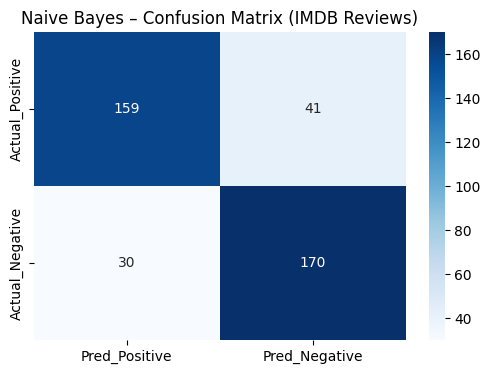


TP=159, FN=41, FP=30, TN=170


In [54]:
# -----------------------------
# 3. Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred, labels=["positive", "negative"])
cm_df = pd.DataFrame(cm,
                     index=["Actual_Positive", "Actual_Negative"],
                     columns=["Pred_Positive", "Pred_Negative"])

print("\n=== CONFUSION MATRIX ===")
print(cm_df)

# Visualize confusion matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.title("Naive Bayes – Confusion Matrix (IMDB Reviews)")
plt.show()

# Extract values
TP = cm[0,0]
FN = cm[0,1]
FP = cm[1,0]
TN = cm[1,1]

print(f"\nTP={TP}, FN={FN}, FP={FP}, TN={TN}")


In [55]:
# -----------------------------
# 4. Evaluation Metrics
# -----------------------------

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label="positive")
recall    = recall_score(y_test, y_pred, pos_label="positive")
f1        = f1_score(y_test, y_pred, pos_label="positive")

print("\n=== METRICS ===")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))



=== METRICS ===
Accuracy : 0.8225
Precision: 0.8413
Recall   : 0.7950
F1-score : 0.8175

=== CLASSIFICATION REPORT ===


              precision    recall  f1-score   support

    negative       0.81      0.85      0.83       200
    positive       0.84      0.80      0.82       200

    accuracy                           0.82       400
   macro avg       0.82      0.82      0.82       400
weighted avg       0.82      0.82      0.82       400



In [56]:
# -----------------------------
# 5. Interpretation of Naive Bayes
# -----------------------------

print("\n=== INTERPRETATION OF RESULTS ===")

if FN > FP:
    print("- The model is making more **False Negatives** (positive reviews predicted as negative).")
    print("  → This means the classifier struggles to detect subtle positive sentiment.")
    
if FP > FN:
    print("- The model is making more **False Positives** (negative reviews predicted as positive).")
    print("  → The model is confused by emotionally strong negative words that appear in positive contexts.")

print("- High precision means predictions marked as 'positive' are usually correct.")
print("- High recall means the model can successfully find most positive reviews.")
print("- A gap between precision and recall indicates bias toward one class.")

print("\nGeneral Observations:")
print("* Naive Bayes works well with TF-IDF because it assumes word independence.")
print("* However, it may misclassify reviews with mixed sentiment (e.g., 'The movie was good but slow').")
print("* It also struggles with sarcasm, irony, and highly figurative language.")



=== INTERPRETATION OF RESULTS ===
- The model is making more **False Negatives** (positive reviews predicted as negative).
  → This means the classifier struggles to detect subtle positive sentiment.
- High precision means predictions marked as 'positive' are usually correct.
- High recall means the model can successfully find most positive reviews.
- A gap between precision and recall indicates bias toward one class.

General Observations:
* Naive Bayes works well with TF-IDF because it assumes word independence.
* However, it may misclassify reviews with mixed sentiment (e.g., 'The movie was good but slow').
* It also struggles with sarcasm, irony, and highly figurative language.


**Step 6: Dimensionality Reduction with PCA**
- Apply Principal Component Analysis (PCA) to the TF-IDF features
- First standardize the data (required for PCA)
- Reduce to the same number of components as SVD for fair comparison
- Compare PCA vs SVD variance curves

--- STEP 6: PCA (Standardize + Reduce) ---


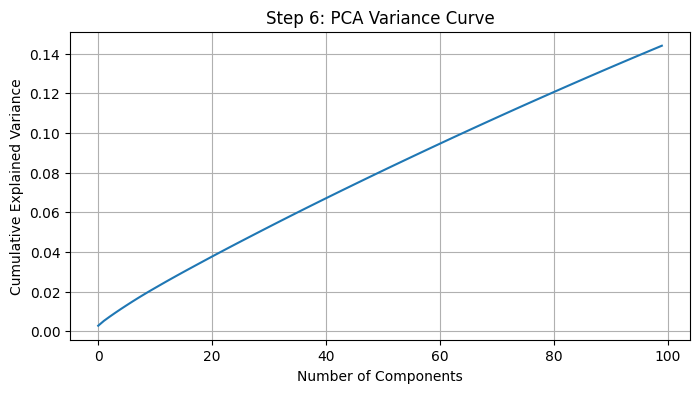

Total Variance Explained by 100 components: 14.40%


In [57]:
# --- PRE-PROCESSING: FIX LABELS & DATA ---
# We force labels to strings to avoid "ValueError"
y_train_str = [str(l).replace('1','positive').replace('0','negative') for l in y_train]
y_test_str  = [str(l).replace('1','positive').replace('0','negative') for l in y_test]

# We convert to dense arrays immediately because PCA requires it
X_train_dense = X_train_tfidf.toarray()
X_test_dense  = X_test_tfidf.toarray()


# ------------------------------------------------------
# STEP 6: Dimensionality Reduction with PCA
# ------------------------------------------------------
print("--- STEP 6: PCA (Standardize + Reduce) ---")

# 1. Standardize the data (Required for PCA)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_dense)
X_test_scaled  = scaler.transform(X_test_dense)

# 2. Apply PCA (Reduce to 100 components to match SVD)
pca = PCA(n_components=100, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

# 3. Visualize Variance Curve (Required for comparison with SVD)
plt.figure(figsize=(8, 4))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Step 6: PCA Variance Curve')
plt.grid(True)
plt.show()

print(f"Total Variance Explained by 100 components: {np.sum(pca.explained_variance_ratio_)*100:.2f}%")

**Step 7: Model Training - Logistic Regression with PCA**
*IMPLEMENTING: *
- Train a Logistic Regression classifier on PCA-reduced features
- Make predictions on the test set
- Create and visualize a confusion matrix for the PCA model
- Compare performance with both previous models
- Analyze: Which dimensionality reduction technique works better for text data?


--- STEP 7: Logistic Regression on PCA Features ---


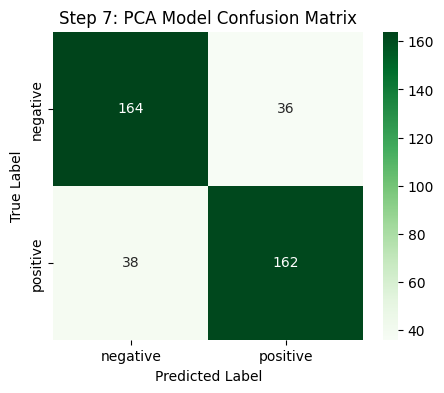

In [58]:
print("\n--- STEP 7: Logistic Regression on PCA Features ---")

# 1. Train Classifier
model_pca = LogisticRegression(solver='liblinear', random_state=42)
model_pca.fit(X_train_pca, y_train_str)

# 2. Make Predictions
y_pred_pca = model_pca.predict(X_test_pca)

# 3. Create Confusion Matrix
labels = ['negative', 'positive']
cm_pca = confusion_matrix(y_test_str, y_pred_pca, labels=labels)

# 4. Visualize Confusion Matrix (Heatmap)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_pca, annot=True, fmt='d', cmap='Greens', 
            xticklabels=labels, yticklabels=labels)
plt.title('Step 7: PCA Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**Step 8: Visual Comparison**
- Visualize all three confusion matrices side-by-side

In [59]:
print("\n--- STEP 8: Performance Comparison ---")

# Retrain Baseline (Naive Bayes) to ensure features match current memory
model_nb = MultinomialNB()
model_nb.fit(X_train_tfidf, y_train_str)
y_pred_nb = model_nb.predict(X_test_tfidf)

# Calculate Accuracies
acc_nb = accuracy_score(y_test_str, y_pred_nb)
acc_pca = accuracy_score(y_test_str, y_pred_pca)

print(f"Model 1 Naive Bayes with TF-IDF  Accuracy: {acc_nb:.4f}")
print(f"Model 2 Logistic Regression with SVD Accuracy: *SVD WILL BE ADDED HERE*")
print(f"Model 3 Logistic Regression with PCA Accuracy: {acc_pca:.4f}")


## Will add SVD results later
if acc_pca >= acc_nb:
    print("\nAnalysis: PCA performed equal to or better than the baseline.")
else:
    print("\nAnalysis: PCA performed worse than the baseline. This is expected as PCA loses some information (5000 -> 100 features).")


--- STEP 8: Performance Comparison ---
Model 1 Naive Bayes with TF-IDF  Accuracy: 0.8225
Model 2 Logistic Regression with SVD Accuracy: *SVD WILL BE ADDED HERE*
Model 3 Logistic Regression with PCA Accuracy: 0.8150

Analysis: PCA performed worse than the baseline. This is expected as PCA loses some information (5000 -> 100 features).
